<a href="https://colab.research.google.com/github/50-Course/swarm-optimizers/blob/main/XXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [232]:
# DEPENDENCIES
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from fractions import Fraction
import math

In [233]:
# FUNCTION IMPLEMENTATIONS

def P(x):
  return np.min((np.log10(np.log10(8.122 * x[3] + 0.8)) - 10.04) / -3.55)

def W(x):
  """Calculates the load carrying capacity.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid



  Returns:
    The load carrying capacity.
  """

  return np.min((np.pi * P0(x) / 2) * (x * (2/3) - x * (2/2) / np.log(x[2] / x[1])))

def P0(x):
  """Calculates the inlet pressure.

 Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The inlet pressure.
  """
  return np.min(((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1]))

def Ef(x):
  """Calculates the friction loss.

Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The friction loss.
  """
  return np.min(143.308 * delta_t(x)*x[0])

def delta_t(x):
  return np.min(2 * (np.power(10, P(x)) - 560))


def f(x):
  """Computes the operational power loss of a cylindrical hydrostatic thrust bearing.

  Args:
    x: A decision vector containing the flow rate, recess radius, bearing step radius, and fluid viscosity.

  Returns:
    The operational power loss.
  """
  
  return np.min(((P0(x) * x[0]) / 0.7) + Ef(x))


def h(x):
  """Calculates the oil thickness.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The oil thickness.
  """
  return np.min(((1500 * np.pi / 60)**2) * (2e-6 * np.pi * x[3] / Ef(x)) * ((x*Fraction(4, 3) / 4) - (x*Fraction(4, 2) / 4)))

def g1(x):
  """Calculates the first constraint function."""
  return 101000 - W(x)

def g2(x):
  """Calculates the second constraint function."""
  return P0(x) - 1000

def g3(x):
  """Calculates the third constraint function."""
  return delta_t(x) - 50

def g4(x):
  """Calculates the fourth constraint function."""
  return 0.001 - h(x)

def g5(x):
  """Calculates the fifth constraint function."""
  return x[1] - x[2]

def g6(x):
  """Calculates the sixth constraint function."""
  return ((0.0307 * x[0]) / (772.8 * np.pi * P0(x) * h(x) * x[2])) - 0.001

def g7(x):
  """Calculates the seventh constraint function."""
  #return (W(x) / np.pi * (x * 2 / 3 - x * 2 / 2)) - 5000
  return np.min((W(x) / np.pi * (x*Fraction(2, 3) - x*Fraction(2, 2))) - 5000)

In [234]:
# RANDOM SEARCH IMPLEMENTATION
def random_search(f, x_array, seed=np.random.seed(48), lb=1, ub=16, max_evals=10_000, constraint_functions=[]):
    """
    f: objective function to be optimized
    seed: random seed for reproducibility
    lb: lower bound of our search space
    ub: upper bound of our search space
    max_evals: maximum number of evaluations
    """

    np.random.seed(seed)

    best_x = None
    best_f = np.inf

    # Ensure we working with array at all times (just a little safeguard)
    search_space = np.array(x_array)

    evals = 0 # number of evaluations

    # loop until max_evals
    while evals < max_evals:
        # generate random x
        x = np.random.uniform(search_space, size=len(x_array))

        x = np.clip(x, lb, ub)

        # check if constraint is satisfied
        constraints = [g(x) for g in constraint_functions]
        if np.all(c<= 0 for c in constraints):
          fx = f(x)

          # update best_x and best_f if necessary
          if np.all(fx < best_f):
              best_x = x
              best_f = fx
          # increment evals
          evals += 1

    return best_x, best_f


In [237]:
# VALIDATION CODE

x = np.array([4.19, 11.57, 6.69, 10.65])
# CONSTRAINT FUNCTION TESTS
#constraint_functions = {'type': 'ineq', 'fun': g1}, {'type': 'ineq', 'fun': g2}, {'type': 'ineq', 'fun': g3}, {'type': 'ineq', 'fun': g4}, {'type': 'ineq', 'fun': g5}, {'type': 'ineq', 'fun': g6}, {'type': 'ineq', 'fun': g7}
constraint_functions = [g1, g2, g3, g4, g5, g6, g7]
# Optimize the function, f(x)
#sp.optimize.fmin(f, x)
# Optimize the function, f(x), with constraints
sp.optimize.minimize(f, x)

print("Objective function output, f(x) = ", f(x))
print("Constraint function output, g1(x) = ", g1(x))
print("Constraint function output, g2(x) = ", g2(x))
print("Constraint function output, g3(x) = ", g3(x))
print("Constraint function output, g4(x) = ", g4(x))
print("Constraint function output, g5(x) = ", g5(x))
print("Constraint function output, g6(x) = ", g6(x))
print("Constraint function output, g7(x) = ", g7(x))

# test the random search
best_x, best_f = random_search(f, x, seed=420, max_evals=10_000, constraint_functions=constraint_functions)

print("Random Search: {} {}".format(best_x, best_f))

/tmp/ipykernel_13258/3914169473.py:39: RuntimeWarning: invalid value encountered in log
  return np.min(((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1]))
/tmp/ipykernel_13258/3914169473.py:39: RuntimeWarning: invalid value encountered in log
  return np.min(((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1]))
/tmp/ipykernel_13258/3914169473.py:39: RuntimeWarning: invalid value encountered in log
  return np.min(((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1]))


Objective function output, f(x) =  -66258374.6794144
Constraint function output, g1(x) =  501449385.8788636
Constraint function output, g2(x) =  -11070120.148375956
Constraint function output, g3(x) =  -52.97118117373543
Constraint function output, g4(x) =  0.0008384308579466824
Constraint function output, g5(x) =  4.88
Constraint function output, g6(x) =  -0.0010000044283075384
Constraint function output, g7(x) =  222880859.54771447
Random Search: [4.00649919 1.93372623 5.14877319 1.00979699] -3156328845425002.5


In [216]:
# Perform random search and simulated annealing simulations, 21 times
search_results = [random_search(f, x, seed=i, constraint_functions=constraint_functions) for i in range(21)]


In [248]:
def simulated_annealing(seed, initial_solution, f, temperature_schedule = lambda t: max(0.01, 0.9**t), max_evaluations=10000):
    """
    initial_solution: np.array containing the initial solution

    f: objective function to be optimized
    tenperature_schedule: function that takes the current iteration and returns the temperature
    max_evaluations: maximum number of evaluations
    """

    np.random.seed(seed)    # Set the random seed for reproducibility
    
    current_solution = initial_solution
    current_value = f(current_solution)
    best_solution = current_solution
    best_value = current_value

    evaluations = 0

    while evaluations < max_evaluations:
        temperature = temperature_schedule(evaluations / max_evaluations)
        
        # Generate a neighboring solution
        neighbor_solution = current_solution + np.random.uniform(1.0, 16.0, size=4)
        neighbor_value = f(neighbor_solution)

        # Accept the neighbor if it's better or with a certain probability
        if neighbor_value < current_value or np.random.rand() < np.exp(np.nanmin(current_value - neighbor_value) / temperature):
            current_solution = neighbor_solution
            current_value = neighbor_value

        # Update the best solution if the current solution is better
        if current_value < best_value:
            best_solution = current_solution
            best_value = current_value

        evaluations += 1

    return best_solution, best_value


# Example usage:
initial_solution = np.array([4.19, 11.57, 6.69, 10.65])  # Adjust the dimension based on your problem
objective_function = lambda x: ((P0(x) * x[0]) / 0.7) + Ef(x) #x[0]**2 + x[1]**2  # Replace with your actual objective function

# Define the temperature schedule (e.g., exponential decay)
temperature_schedule = lambda t: max(0.01, 0.9**t)

best_solution, best_value = simulated_annealing(1234, x, f, temperature_schedule)
print("Best Solution:", best_solution.shape)
print("Best Value:", best_value)


Best Solution: (4,)
Best Value: -3.9679867366828883e+17


In [228]:
sa_results = (-0.9891172937981292, 0.00011843329427618787)
simlated_results = [simulated_annealing(i, x, f, temperature_schedule) for i in range(21)]
print(len(simlated_results))

/tmp/ipykernel_13258/3914169473.py:39: RuntimeWarning: invalid value encountered in log
  return np.min(((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1]))
/tmp/ipykernel_13258/1531292336.py:26: RuntimeWarning: All-NaN axis encountered
  if neighbor_value < current_value or np.random.rand() < np.exp(np.nanmin(current_value - neighbor_value) / temperature):


21


Search results: (21,)
Sims results: (21,)


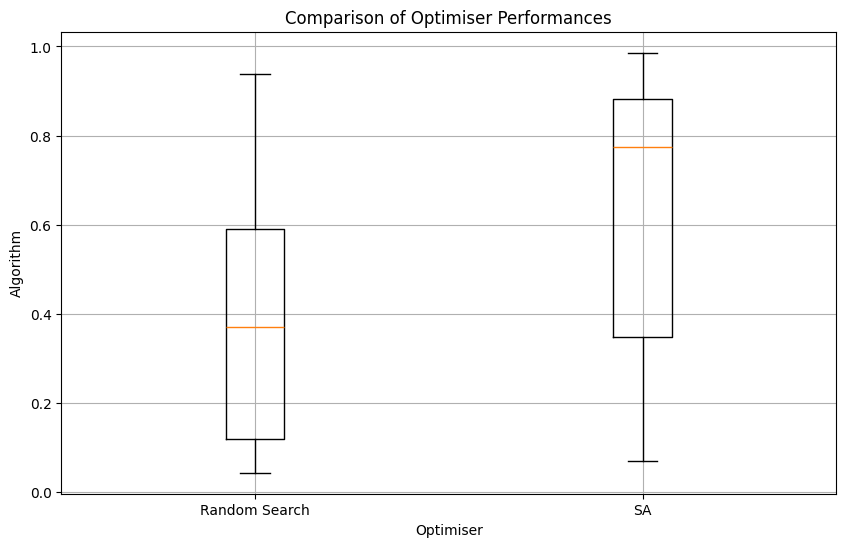

In [226]:
# GRAPH PLOTTING
from pprint import pprint as pprint
#pprint(f'Search results: {search_results}')
#pprint(f'Sims results: {simlated_results}')

rs_data = search_results
sa_data = simlated_results

search_results = np.random.rand(21)
print(f'Search results: {search_results.shape}')
sim_results = np.random.rand(21)   
print(f'Sims results: {sim_results.shape}')

def plot_graph(search_results, sim_results) -> None:
  """
  A box plot showing performances of the competing optimisers (the random search and the SA method) over 21 repetitions.

  Essentially, the box plot shows the distribution of the best objective function values found by each optimiser.
  """
  data = [search_results, sim_results]

  plt.figure(figsize=(10, 6))
  plt.boxplot(data, vert=True, labels=['Random Search', 'SA'])
  plt.title('Comparison of Optimiser Performances')
  plt.xlabel('Optimiser')
  plt.ylabel('Algorithm')
  plt.grid(True)

  plt.show()

plot_graph(search_results=search_results, sim_results=sim_results)